#Họ và tên: Nguyễn Tiến Thịnh
Mã SV: 20E1020078

## Import thư viện

In [24]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

plt.style.use('fivethirtyeight')

##Đọc dữ liệu

In [25]:
tsla = pd.read_csv('TSLA.csv',index_col=0, parse_dates=True)
tsla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-16,628.229980,632.500000,605.000000,622.770020,622.770020,42095800
2020-12-17,628.190002,658.820007,619.500000,655.900024,655.900024,56270100
2020-12-18,668.900024,695.000000,628.539978,695.000000,695.000000,222126200
2020-12-21,666.239990,668.500000,646.070007,649.859985,649.859985,58045300
2020-12-22,648.000000,649.880005,614.229980,640.340027,640.340027,51716000


##Tính SMA và dải trên dưới

In [26]:
#Trung bình của 20 ngày gần nhất
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

tsla['sma_20'] = sma(tsla['Close'], 20)
tsla.tail()

,Open,High,Low,Close,Adj Close,Volume,sma_20
Date,,,,,,,
2021-12-09,1060.640015,1062.489990,1002.359985,1003.799988,1003.799988,19812800,1078.058005
2021-12-10,1008.750000,1020.979980,982.530029,1017.030029,1017.030029,19855000,1075.734006
2021-12-13,1001.090027,1005.000000,951.419983,966.409973,966.409973,26198500,1072.383502
2021-12-14,945.000000,966.409973,930.000000,958.510010,958.510010,23602100,1069.639502
2021-12-15,953.210022,978.750000,928.250000,975.989990,975.989990,24768300,1065.702503


In [27]:
#Tính giá trị dải trên, dải dưới
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

tsla['upper_bb'], tsla['lower_bb'] = bb(tsla['Close'], tsla['sma_20'], 20)
tsla.tail()

,Open,High,Low,Close,Adj Close,Volume,sma_20,upper_bb,lower_bb
Date,,,,,,,,,
2021-12-09,1060.640015,1062.489990,1002.359985,1003.799988,1003.799988,19812800,1078.058005,1172.960900,983.155110
2021-12-10,1008.750000,1020.979980,982.530029,1017.030029,1017.030029,19855000,1075.734006,1174.341049,977.126963
2021-12-13,1001.090027,1005.000000,951.419983,966.409973,966.409973,26198500,1072.383502,1181.081697,963.685308
2021-12-14,945.000000,966.409973,930.000000,958.510010,958.510010,23602100,1069.639502,1187.031345,952.247659
2021-12-15,953.210022,978.750000,928.250000,975.989990,975.989990,24768300,1065.702503,1190.262318,941.142687


Vẽ biều đồ BB

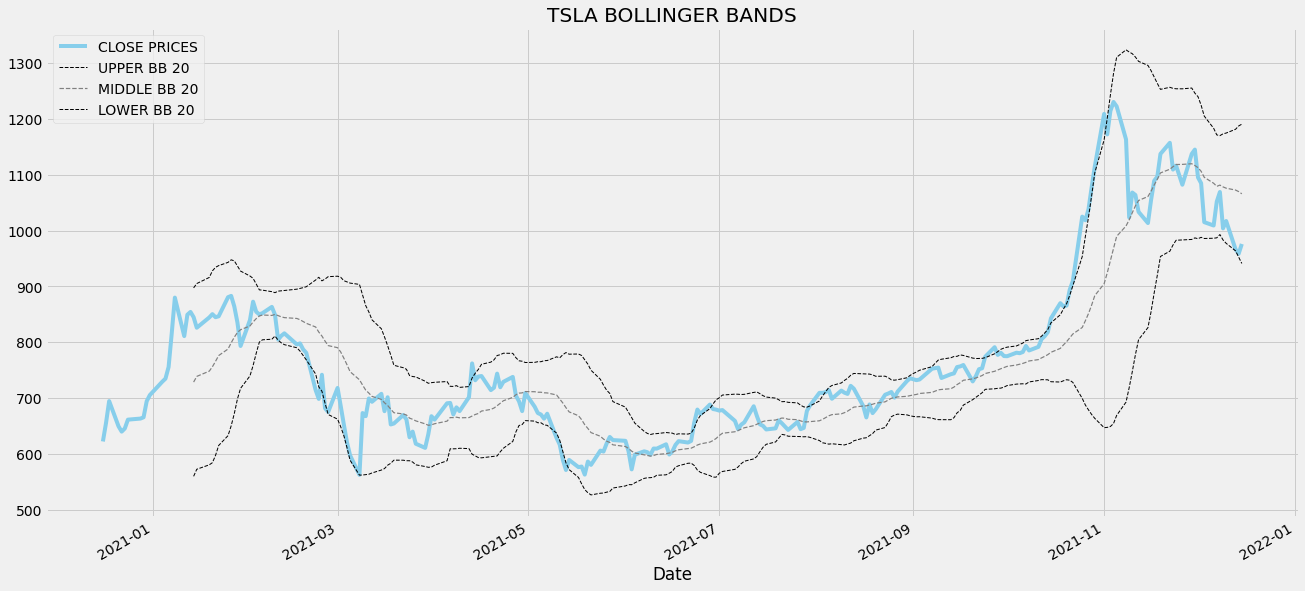

In [28]:
#Vẽ biểu đồ
plt.rcParams['figure.figsize'] = (20, 10)
tsla['Close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
tsla['upper_bb'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
tsla['sma_20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
tsla['lower_bb'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc = 'upper left')
plt.title('TSLA BOLLINGER BANDS')
plt.show()

##Tạo chiến lược giao dịch

In [29]:
#Hàm thực hiện tín hiệu mua bán
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    
    for i in range(len(data)):
        signal = 0
        #Khi giá của ngày trước lớn hơn giá trị dải dưới và giá ngày hôm nay thấp hơn dải dưới
        #thì ta sẽ bắt đầu mua
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            #if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
        #Ngược lại thì nếu giá ngày hôm trước thấp hơn dải trên và giá hôm nay lại cao hơn dải trên
        #thì ta sẽ bắt đầu bán
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            #if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
        #Còn lại thì chúng ta không thực hiện mua bán
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

buy_price, sell_price, bb_signal = implement_bb_strategy(tsla['Close'], tsla['lower_bb'], tsla['upper_bb'])

##Vẽ các tín hiệu giao dịch

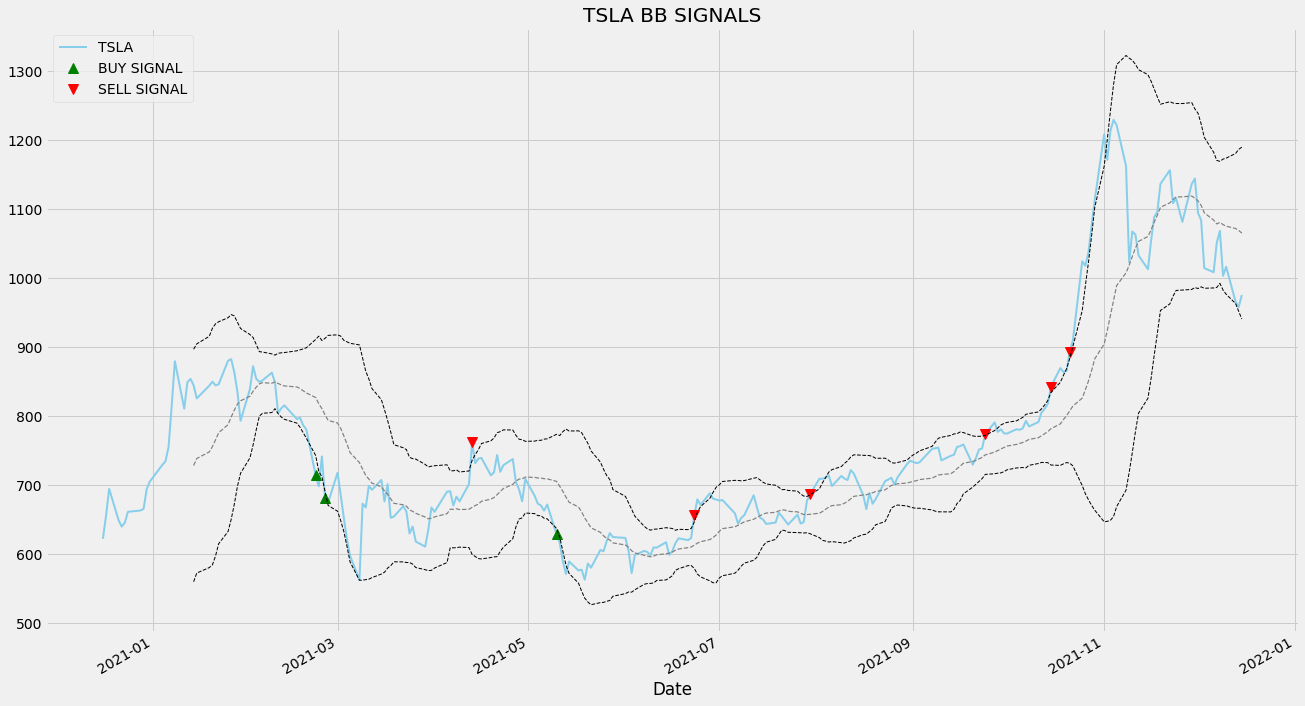

In [30]:
plt.rcParams['figure.figsize'] = (20, 20)
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax1.plot(tsla['Close'], color = 'skyblue', linewidth = 2, label = 'TSLA')
ax1.plot(tsla.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(tsla.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('TSLA BB SIGNALS')
tsla['upper_bb'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
tsla['sma_20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
tsla['lower_bb'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.show()

##Triển khai đầu tư

In [31]:
position = []
for i in range(len(bb_signal)):
    if bb_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(tsla['Close'])):
    if bb_signal[i] == 1:
        position[i] = 1
    elif bb_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
upper_bb = tsla['upper_bb']
lower_bb = tsla['lower_bb']
close_price = tsla['Close']
bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(tsla.index)
position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(tsla.index)

frames = [close_price, upper_bb, lower_bb, bb_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index().drop('Date', axis = 1)

strategy

,Close,upper_bb,lower_bb,bb_signal,bb_position
0,622.770020,NaN,NaN,0,1
1,655.900024,NaN,NaN,0,1
2,695.000000,NaN,NaN,0,1
3,649.859985,NaN,NaN,0,1
4,640.340027,NaN,NaN,0,1
...,...,...,...,...,...
247,1003.799988,1172.960900,983.155110,0,0
248,1017.030029,1174.341049,977.126963,0,0
249,966.409973,1181.081697,963.685308,0,0
250,958.510010,1187.031345,952.247659,0,0


##Backtesting

In [32]:
tsla_ret = pd.DataFrame(np.diff(tsla['Close'])).rename(columns = {0:'returns'})
bb_strategy_ret = []

for i in range(len(tsla_ret)):
    returns = tsla_ret['returns'][i]*strategy['bb_position'][i]
    bb_strategy_ret.append(returns)
    
bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})

investment_value = 100000
number_of_stocks = np.floor(investment_value/tsla['Close'][-1])
bb_investment_ret = []

for i in range(len(bb_strategy_ret_df['bb_returns'])):
    returns = number_of_stocks*bb_strategy_ret_df['bb_returns'][i]
    bb_investment_ret.append(returns)

bb_investment_ret_df = pd.DataFrame(bb_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(bb_investment_ret_df['investment_returns']), 2)
profit_percentage = np.floor((total_investment_ret/investment_value)*100)
print('Lợi nhuận thu được từ chiến lược BB khi đầu tư 100k$ vào TSLA : {}'.format(total_investment_ret))
print('Phần trăm lợi nhuận của chiến lược : {}%'.format(profit_percentage))

Lợi nhuận thu được từ chiến lược BB khi đầu tư 100k$ vào TSLA : 17042.16
Phần trăm lợi nhuận của chiến lược : 17.0%
